In [1]:
import scanpy as sc
import scPAFA
import json
import pandas as pd
import seaborn as sns
import pickle

In [3]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42

In [4]:
#read_adata_and_select_tumor_cells
adata = sc.read_h5ad('/data/scPAFA_paper/CRC_file/20231107_cRc_geneover30cells_withobs.h5ad')
adata = adata[adata.obs['MMRStatusTumor'].isin(['MMRp','MMRd'])]
adata = adata[adata.obs[ 'ClusterMidway'].isin(['EpiT'])]
adata.obs['ClusterFull'] = adata.obs['ClusterFull'].str.replace('/','')
adata.obs['ClusterFull'] =adata.obs['ClusterFull'].astype('category')
#batch_information is infered from table S1 of the Cell article,is 10X chemistry
adata.obs['batch'] = adata.obs['biosample_id'].str[-2:]
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['batch'].value_counts()

batch
v2    71746
v3    36751
Name: count, dtype: int64

In [5]:
#check if 'PatientTypeID' cross >1 batch
check_frame = pd.crosstab(adata.obs['PatientTypeID'],adata.obs['batch'])
selected_rows = check_frame[(check_frame != 0).sum(axis=1) > 1]
selected_rows

batch,v2,v3
PatientTypeID,,
C162_T,3545,3857


In [6]:
#to avoid overlap sample in differernt group
adata.obs['pseudobulk_sample'] = adata.obs['PatientTypeID'].astype(str)+'_'+adata.obs['batch'].astype(str)
adata.obs['pseudobulk_sample'] = adata.obs['pseudobulk_sample'].astype('category')

In [7]:
adata.obs['pseudobulk_sample'].value_counts().sort_values()

pseudobulk_sample
C167_T_v3     286
C151_T_v2     328
C172_T_v3     365
C138_T_v2     460
C115_T_v2     556
             ... 
C170_T_v3    3713
C162_T_v3    3857
C123_T_v2    4031
C103_T_v2    4580
C166_T_v3    4699
Name: count, Length: 65, dtype: int64

In [8]:
#create_sample_meta
sample_meta = adata.obs[['pseudobulk_sample','PatientTypeID','batch','MMRStatusTumor','TumorStage','TissueSource', 'ProcessingMethod','Site', 'Grade']]
sample_meta = sample_meta.drop_duplicates(subset='pseudobulk_sample')
sample_meta.index = sample_meta['pseudobulk_sample']

In [10]:
sample_meta.to_csv('../CRC/CRC_data_reverse/CRC_Pelka_sample_metadata.csv')

In [9]:
pd.crosstab(sample_meta['MMRStatusTumor'],sample_meta['batch'])

batch,v2,v3
MMRStatusTumor,,
MMRd,24,11
MMRp,20,10


In [8]:
Ucell_result = pd.read_parquet('/data/scPAFA_paper/CRC_file/20231109_crc_2k.parquet')
Ucell_result = Ucell_result.loc[adata.obs.index]

In [9]:
pseudobulk_table = scPAFA.pb.generate_scpafa_input_multigroup(metadata=adata.obs,
                                                    PAS_dataframe=Ucell_result,
                                                    min_cell_number_per_sample=10,
                                                    min_percentage_sample_per_view=0.75,
                                                    min_sample_per_view=15,
                                                    sample_column='pseudobulk_sample',
                                                    view_column='ClusterFull',
                                                    group_column='batch',
                                                    top_percentage=0.25)

2 groups indentified
processing group v2
Select the top 408 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable
processing group v3
Select the top 408 pathways with the maximum variance
Done_Qc
Done_matrix
Done_longtable


In [10]:
MOFA_model = scPAFA.pb.run_mofapy2(long_table=pseudobulk_table,
                                   scale_groups=True,
                                   scale_views=True,
                                   factor_number=10,
                                   random_seed=2023,
                                   spikeslab_weights=True,
                                   ard_factors = True,
                                   ard_weights=True,
                                   dropR2=0.01,
                                   convergence_mode='fast')


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\scPAFA        ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Scaling groups to unit variance...



Loaded group='v2' view='Tumor cE01 (StemTA-like)' with N=44 samples and D=408 features...
Loaded group='v2' view='Tumor cE02 (StemTA-likeImmature Goblet)' with N=36 samples and D=408 features...
Loaded group='v2' view='Tumor cE03 (StemTA-like prolif)' with N=44 samples and D=408 features...
Loaded group='v2

Iteration 71: time=0.05, ELBO=-114391.05, deltaELBO=36.982 (0.00409722%), Factors=8
Iteration 72: time=0.05, ELBO=-114354.54, deltaELBO=36.506 (0.00404444%), Factors=8
Iteration 73: time=0.05, ELBO=-114318.55, deltaELBO=35.992 (0.00398755%), Factors=8
Iteration 74: time=0.05, ELBO=-114283.10, deltaELBO=35.442 (0.00392661%), Factors=8
Iteration 75: time=0.05, ELBO=-114248.25, deltaELBO=34.853 (0.00386137%), Factors=8
Iteration 76: time=0.05, ELBO=-114214.03, deltaELBO=34.223 (0.00379147%), Factors=8
Iteration 77: time=0.05, ELBO=-114180.48, deltaELBO=33.544 (0.00371628%), Factors=8
Iteration 78: time=0.05, ELBO=-114147.68, deltaELBO=32.805 (0.00363439%), Factors=8
Iteration 79: time=0.05, ELBO=-114115.69, deltaELBO=31.985 (0.00354361%), Factors=8
Iteration 80: time=0.05, ELBO=-114084.63, deltaELBO=31.068 (0.00344199%), Factors=8
Iteration 81: time=0.05, ELBO=-114054.58, deltaELBO=30.049 (0.00332910%), Factors=8
Iteration 82: time=0.05, ELBO=-114025.63, deltaELBO=28.945 (0.00320679%), Fa

In [11]:
MOFA_model.save('../CRC/mofa_model_CRC/20231227_CRC_mofa_Tumor_multigroup.hdf5')

Saving model in ../CRC/mofa_model_CRC/20231227_CRC_mofa_Tumor_multigroup.hdf5...


In [10]:
import mofax as mfx
MOFA_model = mfx.mofa_model('../CRC/mofa_model_CRC/20231227_CRC_mofa_Tumor_multigroup.hdf5')

In [11]:
factor_matrix = pd.concat(MOFA_model.get_factors(df=True,concatenate_groups =False,scale=True))

In [8]:
MOFA_model.get_r2().to_csv('./CRC_data_reverse/CRC_model_r2.csv')

In [37]:
MOFA_model.get_views()

['Tumor cE01 (StemTA-like)',
 'Tumor cE02 (StemTA-likeImmature Goblet)',
 'Tumor cE03 (StemTA-like prolif)',
 'Tumor cE05 (Enterocyte 2)',
 'Tumor cE06 (Immature Goblet)']

In [36]:
view_list = MOFA_model.get_weights(factors=['Factor2','Factor3','Factor6'],concatenate_views =False,scale=True,df =True)

with open("./CRC_data_reverse/CRC_model_view_weight_list.pkl", 'wb') as file:
    pickle.dump(view_list, file)

In [12]:
sample_meta = sample_meta.loc[factor_matrix.index]

In [13]:
a1 = scPAFA.pl.runumap_and_plot(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='MMRStatusTumor'
                                ,width=7,height=5,random_state=2023,point_size=3,color_mapping={"MMRd":"#4b91c3","MMRp":"#9ecad2"})

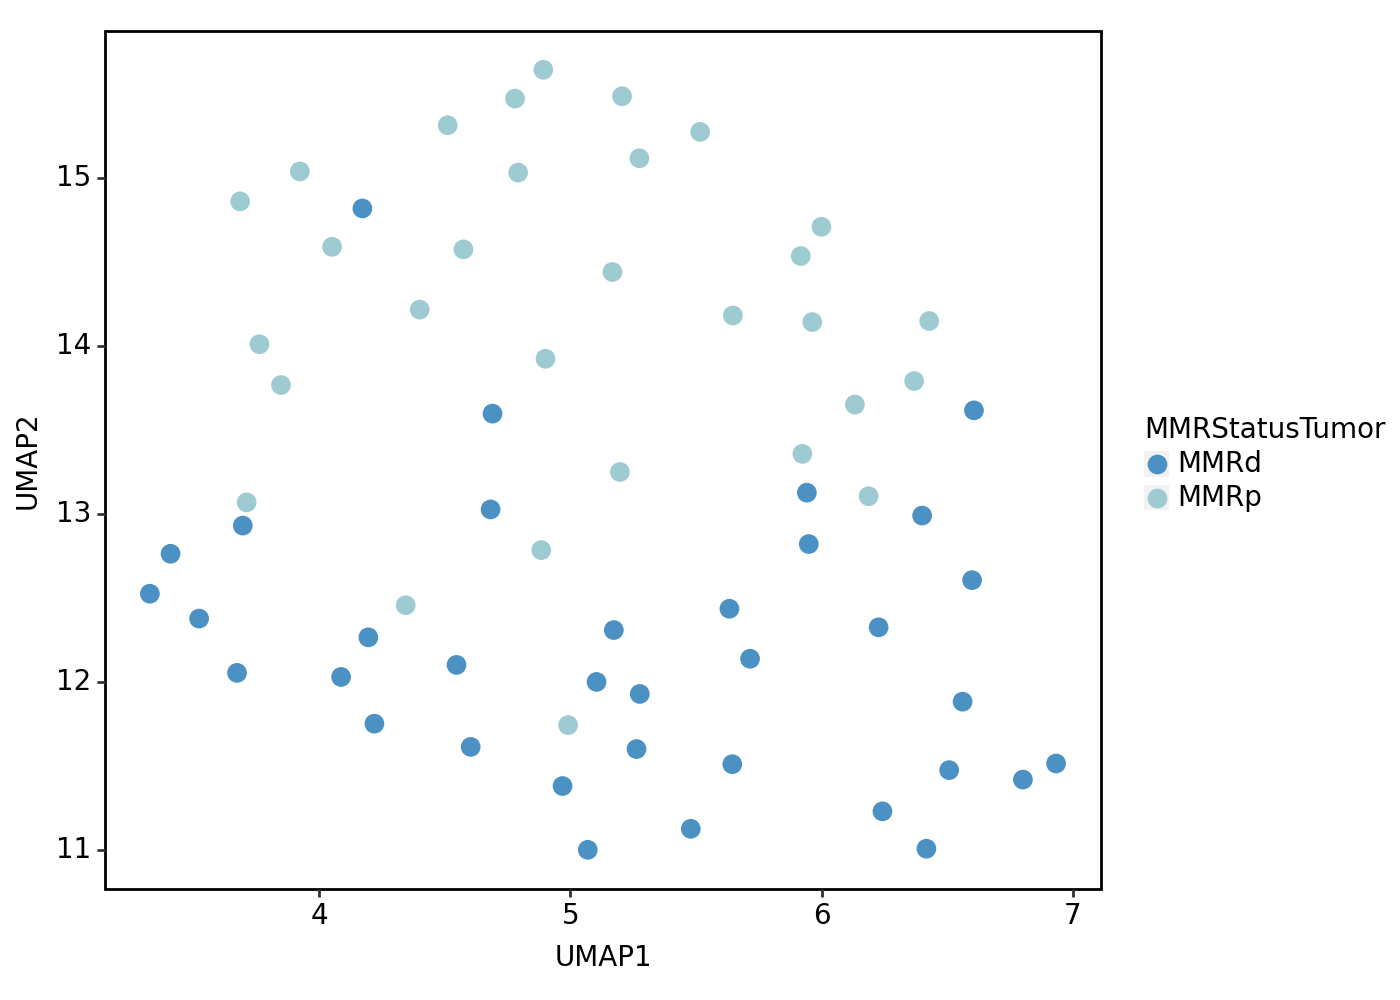

<Figure Size: (700 x 500)>

In [14]:
a1

In [17]:
a1.save('../CRC/figure_CRC/20231227_CRC_umap_MMRstatus.pdf',bbox_inches = "tight")

In [18]:
a1 = scPAFA.pl.runumap_and_plot(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='batch'
                                ,width=6,height=5,random_state=2023,point_size=3,color_mapping={"v2":"#7d7d7d","v3":"#198c68"})

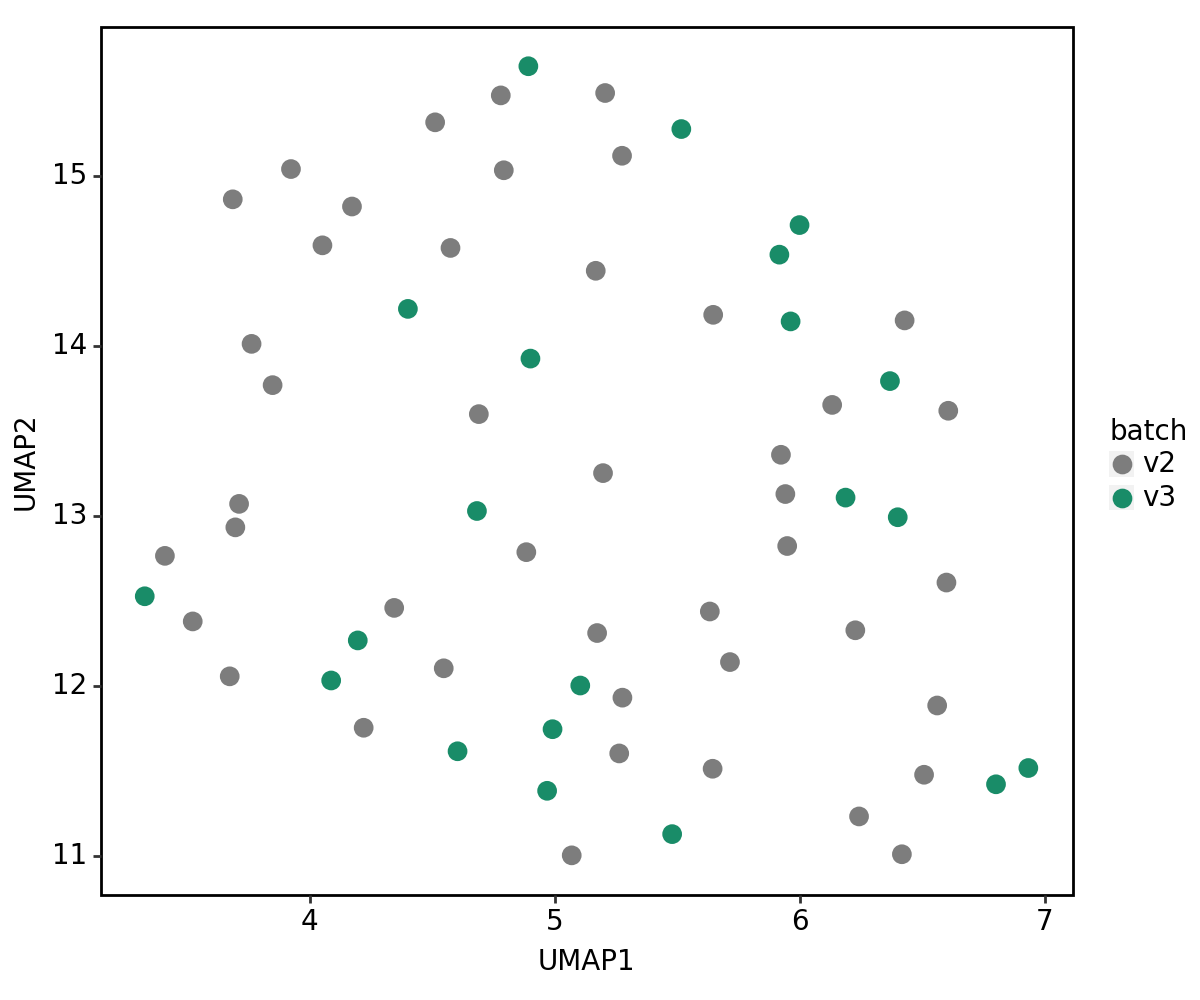

<Figure Size: (600 x 500)>

In [19]:
a1

In [20]:
a1.save('../CRC/figure_CRC/20231227_CRC_umap_batch.pdf',bbox_inches = "tight")

In [15]:
group_test_result = scPAFA.st.normality_and_variance_homogeneity(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='MMRStatusTumor')

Normality or Variance Homogeneity test failed, nonparametric_test_category() is recommended


In [16]:
group_test_result = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta,label_column='MMRStatusTumor')

In [17]:
group_test_result

,Factor,p_value,p_adj,method
0,Factor1,5.063504e-01,0.578686,Mann-Whitney U test
1,Factor2,1.464662e-02,0.039058,Mann-Whitney U test
2,Factor3,1.548111e-04,0.000619,Mann-Whitney U test
3,Factor4,4.979681e-01,0.578686,Mann-Whitney U test
4,Factor5,4.651907e-01,0.578686,Mann-Whitney U test
5,Factor6,8.305088e-07,0.000007,Mann-Whitney U test
6,Factor7,9.737563e-01,0.973756,Mann-Whitney U test
7,Factor8,1.252691e-01,0.250538,Mann-Whitney U test


In [18]:
group_test_result_batch = scPAFA.st.nonparametric_test_category(sample_factor_df=factor_matrix,metadata=sample_meta,label_column="batch")

In [19]:
group_test_result_batch

,Factor,p_value,p_adj,method
0,Factor1,0.569956,0.972025,Mann-Whitney U test
1,Factor2,0.838823,0.972025,Mann-Whitney U test
2,Factor3,0.972025,0.972025,Mann-Whitney U test
3,Factor4,0.838823,0.972025,Mann-Whitney U test
4,Factor5,0.949668,0.972025,Mann-Whitney U test
5,Factor6,0.871844,0.972025,Mann-Whitney U test
6,Factor7,0.905090,0.972025,Mann-Whitney U test
7,Factor8,0.720565,0.972025,Mann-Whitney U test


In [20]:
factor_matrix_long = factor_matrix.copy()
factor_matrix_long.loc[:,'MMRStatusTumor'] =  sample_meta.loc[factor_matrix_long.index,:]['MMRStatusTumor']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','MMRStatusTumor'], var_name='Factor', value_name='Value')

In [41]:
plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


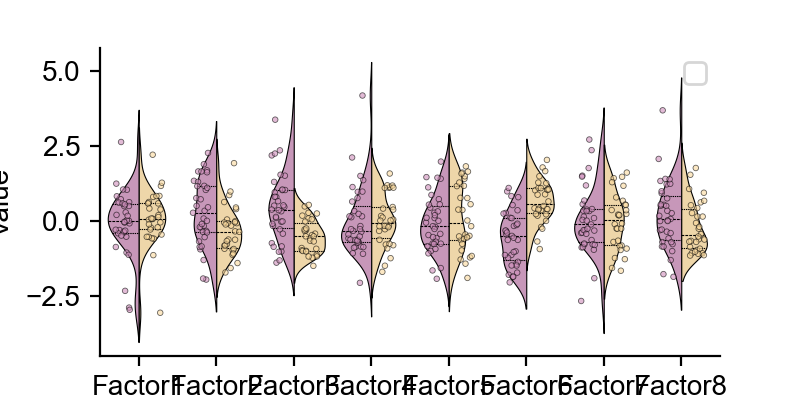

In [53]:
plt.figure(figsize=(4, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue="MMRStatusTumor", split=True, inner="quart",palette=["#cf8fbc","#fad99d"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="MMRStatusTumor", 
              dodge=True, jitter=0.2, alpha=0.9, size=2 ,palette=["#cf8fbc","#fad99d"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
sns.despine()
plt.savefig('../CRC/figure_CRC/20241104_CRC_split_violin_MMRStatus.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [54]:
factor_matrix_long = factor_matrix.copy()
factor_matrix_long.loc[:,'batch'] =  sample_meta.loc[factor_matrix_long.index,:]['batch']
factor_matrix_long.reset_index(inplace=True)
factor_matrix_long = pd.melt(factor_matrix_long, id_vars=['index','batch'], var_name='Factor', value_name='Value')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


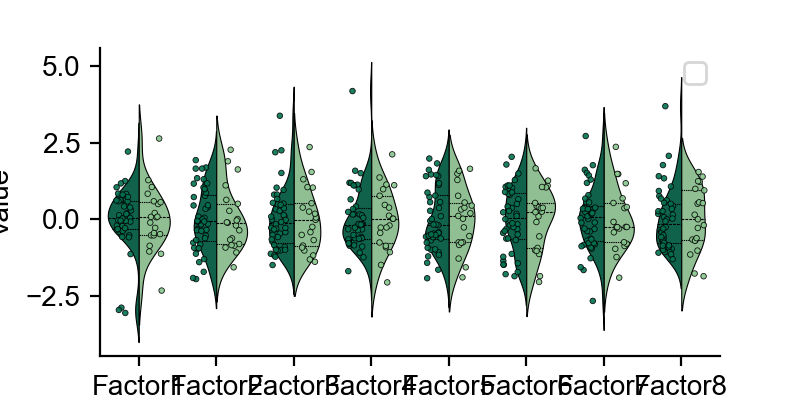

In [57]:
plt.figure(figsize=(4, 2))
sns.violinplot(data=factor_matrix_long, x="Factor", y="Value", hue="batch", split=True, inner="quart",palette=["#027150","#88c78e"],edgecolor='black',linewidth=0.4,legend=False)
sns.stripplot(data=factor_matrix_long, x="Factor", y="Value", hue="batch", 
              dodge=True, jitter=0.2, alpha=0.9, size=2 ,palette=["#027150","#88c78e"],edgecolor='black', linewidth=0.3,legend=False)
plt.legend(loc=None) 
sns.despine()
plt.savefig('../CRC/figure_CRC/20241104_CRC_split_violin_batch.pdf',bbox_inches = "tight", transparent=True)
plt.show()

In [30]:
a2 = scPAFA.pl.plot_factor_scatter_2D(sample_factor_df=factor_matrix,
                                 metadata=sample_meta,
                                 label_column='MMRStatusTumor',
                                 factor_x='Factor3',
                                 factor_y='Factor6',
                                 width=5,height=4,color_mapping={"MMRd":"#4b91c3","MMRp":"#9ecad2"})

In [31]:
a2.save('../CRC/figure_CRC/20231227_CRC_2factor_umap_3_6.pdf',bbox_inches = "tight")

In [32]:
cmaps={'MMRStatusTumor':'tab20','batch':'Dark2_r'}

In [33]:
a1 = scPAFA.pl.draw_cluster_heatmap(sample_factor_df=factor_matrix[['Factor2','Factor3','Factor6']],
                              sample_annotaion_df=pd.DataFrame(sample_meta[['batch','MMRStatusTumor']]),
                              p_value_dataframe=group_test_result,custom_cmap=cmaps,
                              figsize = (8,8))

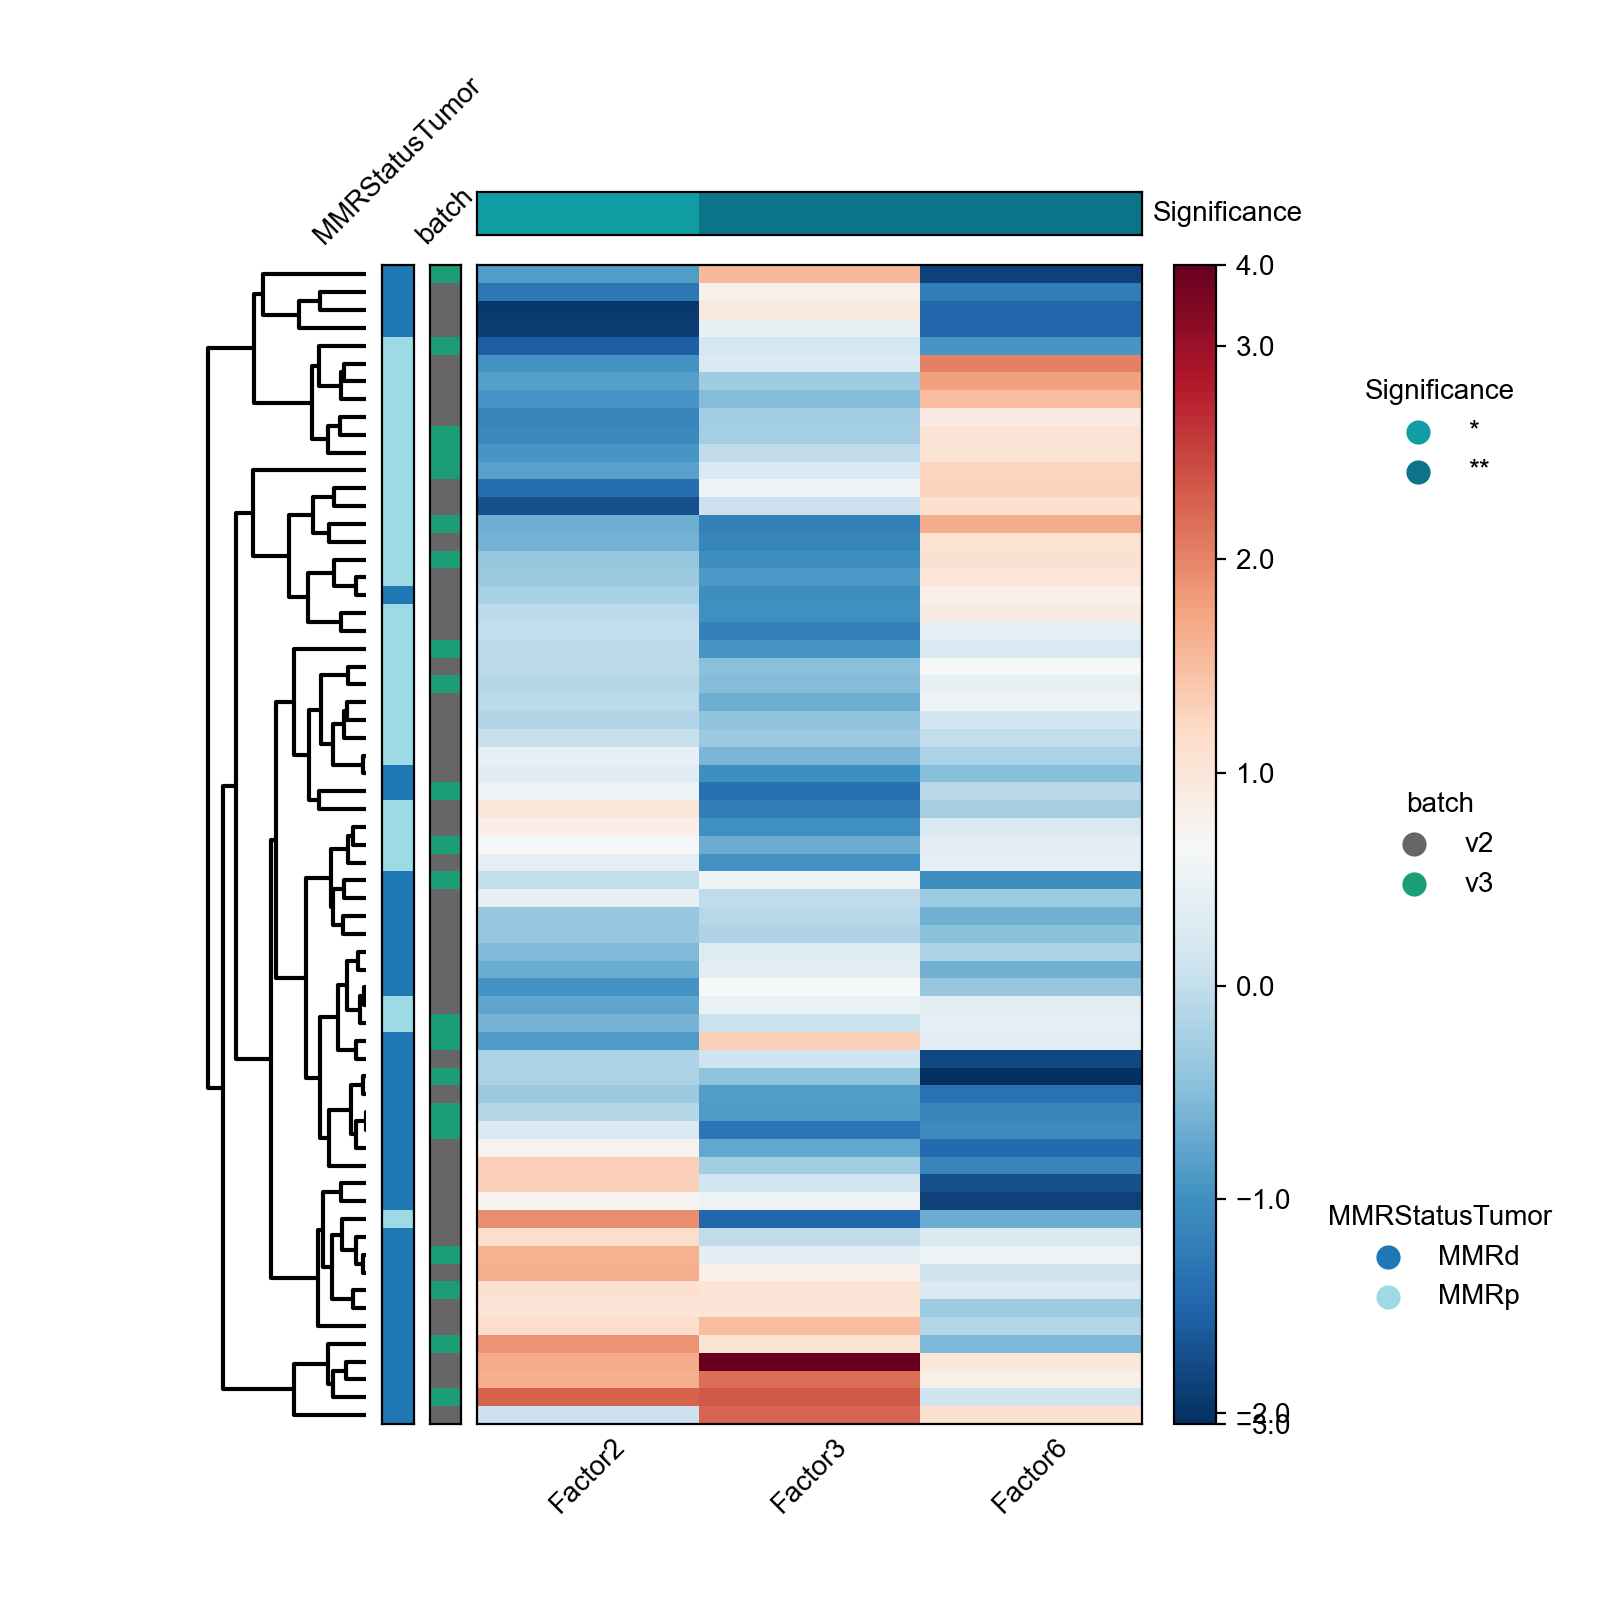

In [34]:
a1

In [35]:
a1.savefig('../CRC/figure_CRC/20231227_CRC_cluster_heatmap_factor2_3_6.pdf',bbox_inches = "tight")

In [36]:
#modification of MFX.plot_r2 function
def plot_r2(
    model,
    x="Group",
    y="Factor",
    factors =None,
    groups_df: pd.DataFrame = None,
    group_label: str = None,
    views=None,
    groups=None,
    cmap="Blues",
    vmin=None,
    vmax=None,
    **kwargs,
):
    """
    Plot R2 values for the model

    Parameters
    ----------
    model : mofa_model
        Factor model
    x : str
        Dimension along X axis: Group (default), View, or Factor
    y : str
        Dimension along Y axis: Group, View, or Factor (default)
    factors : optional
        Index of a factor (or indices of factors) to use (all factors by default)
    views : optional
        Make a plot for certain views (None by default to plot all views)
    groups : optional
        Make a plot for certain groups (None by default to plot all groups)
    group_label : optional
        Sample (cell) metadata column to be used as group assignment
    groups_df : optional pd.DataFrame
        Data frame with samples (cells) as index and first column as group assignment
    cmap : optional
        The colourmap for the heatmap (default is 'Blues' with darker colour for higher R2)
    vmin : optional
        Display all R2 values smaller than vmin as vmin (0 by default)
    vmax : optional
        Display all R2 values larger than vmax as vmax (derived from the data by default)
    """
    r2 = model.get_r2(
        factors=factors,
        groups=groups,
        views=views,
        group_label=group_label,
        groups_df=groups_df,
    )

    vmax = r2.R2.max() if vmax is None else vmax
    vmin = 0 if vmin is None else vmin

    split_by = [dim for dim in ["Group", "View", "Factor"] if dim not in [x, y]]
    assert (
        len(split_by) == 1
    ), "x and y values should be different and be one of Group, View, or Factor"
    split_by = split_by[0]

    split_by_items = r2[split_by].unique()
    fig, axes = plt.subplots(ncols=len(split_by_items), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
    if len(split_by_items) == 1:
        axes = [axes]

    for i, item in enumerate(split_by_items):
        r2_sub = r2[r2[split_by] == item]
        r2_df = r2_sub.sort_values("R2").pivot(index=y, columns=x, values="R2")

        if y == "Factor":
            # Sort by factor index
            r2_df.index = r2_df.index.astype("category")
            r2_df.index = r2_df.index.reorder_categories(
                sorted(r2_df.index.categories, key=lambda x: int(x.split("Factor")[1]))
            )
            r2_df = r2_df.sort_values("Factor")

        if x == "Factor":
            # Re-order columns by factor index
            r2_df.columns = r2_df.columns.astype("category")
            r2_df.columns = r2_df.columns.reorder_categories(
                sorted(
                    r2_df.columns.categories, key=lambda x: int(x.split("Factor")[1])
                )
            )
            r2_df = r2_df[r2_df.columns.sort_values()]

        g = sns.heatmap(
            r2_df.sort_index(level=0, ascending=False),
            ax=axes[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=i == 0,
            cbar_ax=None if i else cbar_ax,
            **kwargs,
        )
        axes[i].set_title(item,rotation = 90,size =5)
        axes[i].tick_params(axis="both", which="both", length=0)

        if i == 0:
            g.set_yticklabels(g.yaxis.get_ticklabels(), rotation=0)
        else:
            axes[i].set_ylabel("")
    plt.tight_layout()
    #plt.show()
    return fig

In [37]:
plot_r2(MOFA_model,factors=['Factor2','Factor3','Factor6'],cmap="Blues")
plt.savefig('../CRC/figure_CRC/20231227_CRC_r2_heatmap_factor2_3_6.pdf',bbox_inches = "tight")

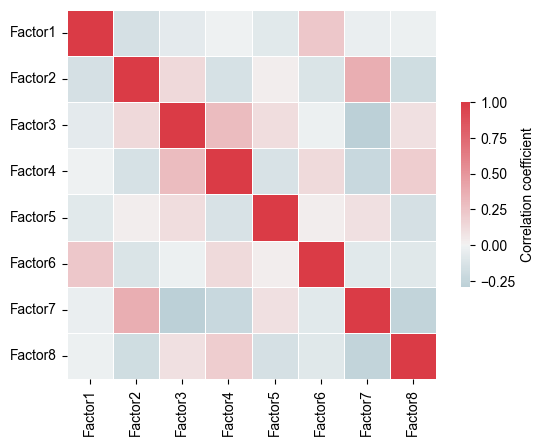

In [20]:
mfx.plot_factors_correlation(MOFA_model)
plt.savefig('../CRC/figure_CRC/20231227_CRC_factor_corr.pdf',bbox_inches = "tight",transparent=True)
plt.show()

In [14]:
?mfx.plot_factors_correlation

In [39]:
weight_matrix = pd.concat(MOFA_model.get_weights(concatenate_views =False,scale=True,df =True))

In [40]:
weight_matrix.to_csv('../CRC/20231228_CRC_weight_matrix.csv')

In [3]:
weight_matrix = pd.read_csv('../CRC/20231228_CRC_weight_matrix.csv',index_col=0)

In [3]:
weight_matrix

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8
bioplanet_1529_Endosomal/vacuolar pathway_View_Tumor cE01 (StemTA-like),0.686277,2.826685,3.050911,-0.065750,1.719641,4.381969,-0.357975,-1.064239
GAVISH_3CA_MALIGNANT_METAPROGRAM_17_INTERFERON_MHC_II_1_View_Tumor cE01 (StemTA-like),-1.518922,3.108574,5.215108,-0.320869,-0.715395,2.193690,-0.348167,-1.268768
bioplanet_1105_Chemiosmotic coupling formation of ATP_View_Tumor cE01 (StemTA-like),3.519541,-3.101258,2.807305,-0.674708,-1.468972,0.263352,-0.262851,-1.048987
bioplanet_1537_Folding of actin by CCT/TriC_View_Tumor cE01 (StemTA-like),0.057369,-4.176271,-0.213292,0.804222,-2.012863,3.821150,-0.649345,1.724173
GAVISH_3CA_METAPROGRAM_B_CELLS_METABOLISM_MYC_View_Tumor cE01 (StemTA-like),0.060732,-3.231309,1.833093,0.028139,-2.508113,0.535262,-1.726890,3.691770
...,...,...,...,...,...,...,...,...
bioplanet_491_Signaling events mediated by HDAC class II_View_Tumor cE06 (Immature Goblet),-0.068815,-0.221207,-0.314001,-0.158171,-0.110008,-0.149951,1.321579,0.170007
bioplanet_1160_Destabilization of mRNA by butyrate response factor 1 (BRF1)_View_Tumor cE06 (Immature Goblet),1.429571,-0.220288,-1.048264,-0.719390,0.142077,1.490890,0.879101,-0.320682
bioplanet_1503_Clathrin derived vesicle budding_View_Tumor cE06 (Immature Goblet),-0.096679,-0.279054,-0.359407,-0.175603,0.103505,0.078076,0.612001,-0.311130
bioplanet_927_Cell cycle negative regulation by p75 neurotrophin receptor_View_Tumor cE06 (Immature Goblet),-1.407263,-0.255327,-0.459526,-0.806196,-0.386941,-0.417378,-0.650076,-0.057719


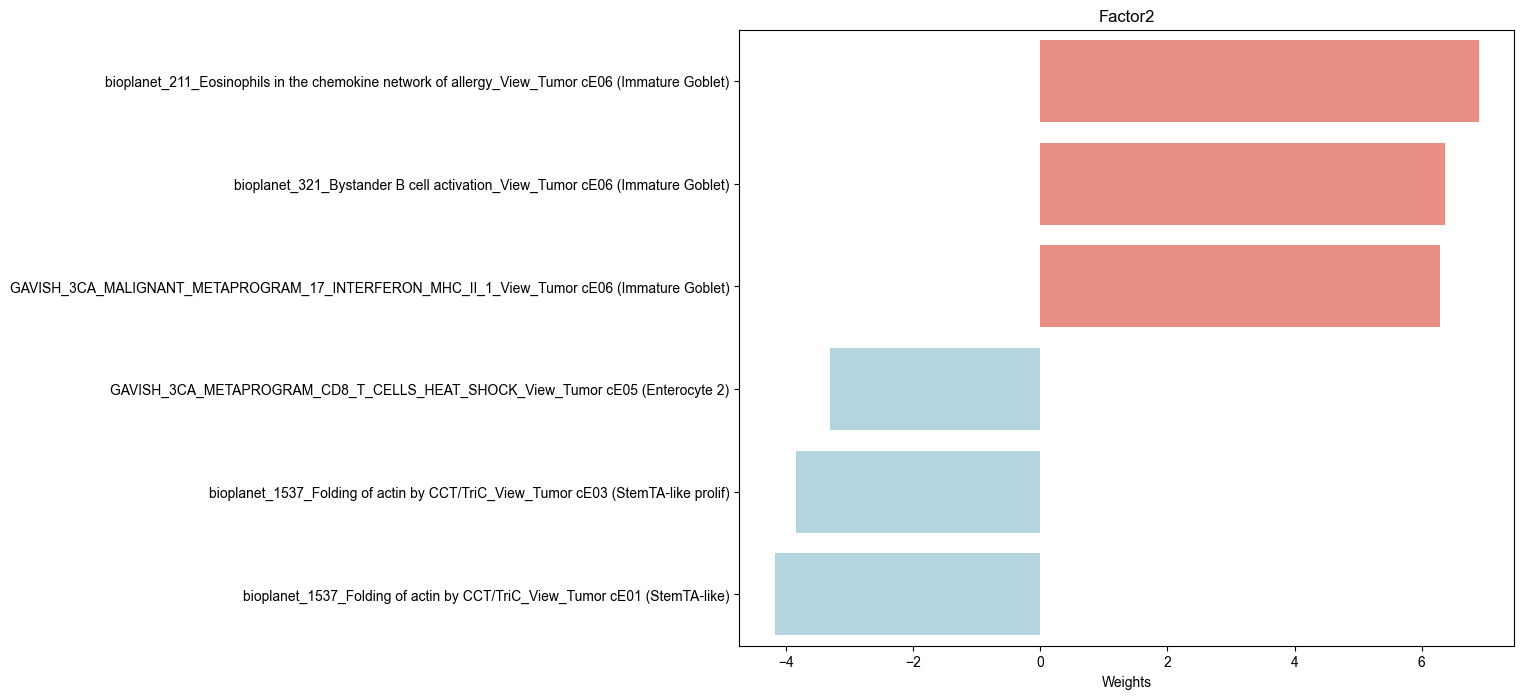

In [9]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor2',label_beside_bar=False,n_largest=3,n_smallest=3)
a1.savefig('../CRC/figure_CRC/20240103_CRC_cluster_butterfly_factor2.pdf',bbox_inches = "tight")
plt.show()

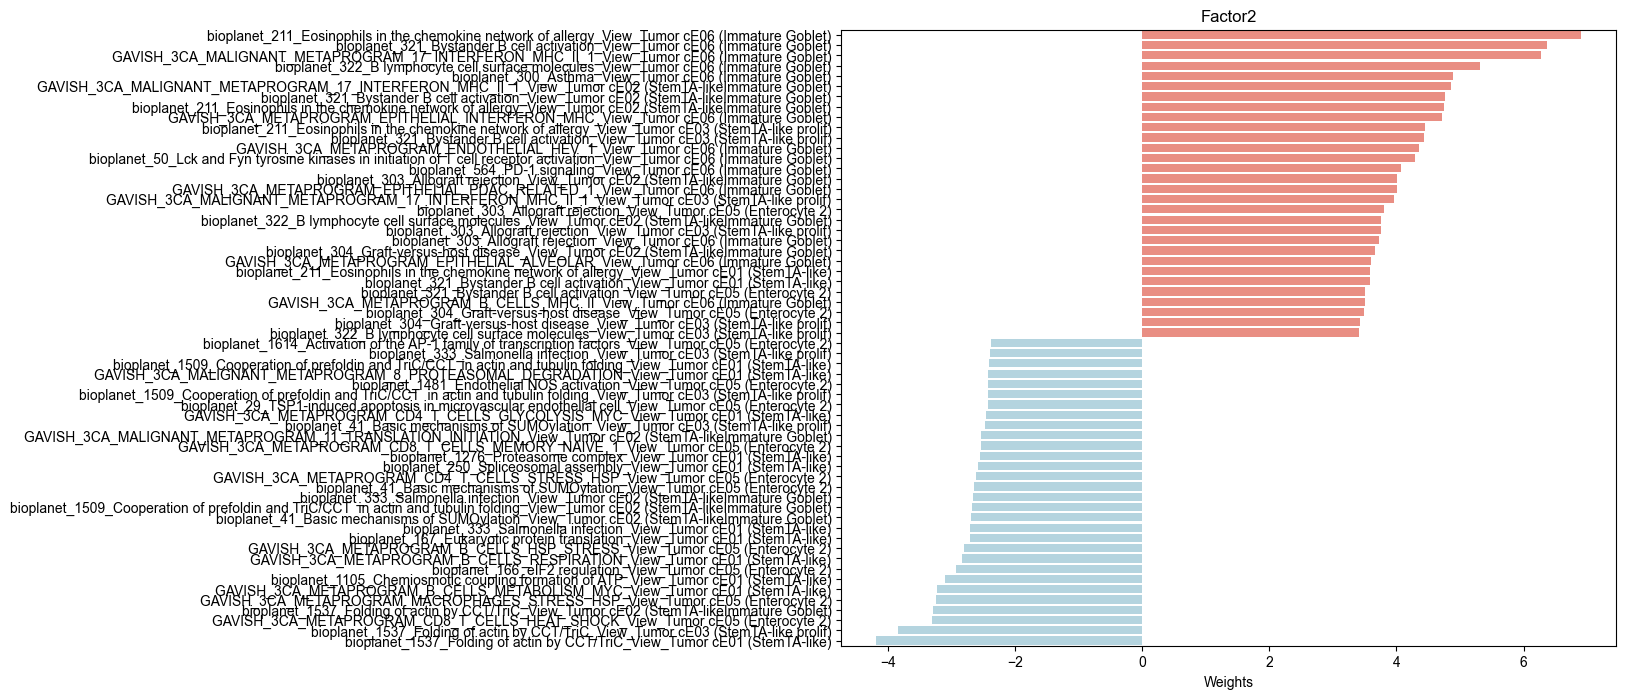

In [4]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor2',label_beside_bar=False,n_largest=30,n_smallest=30)

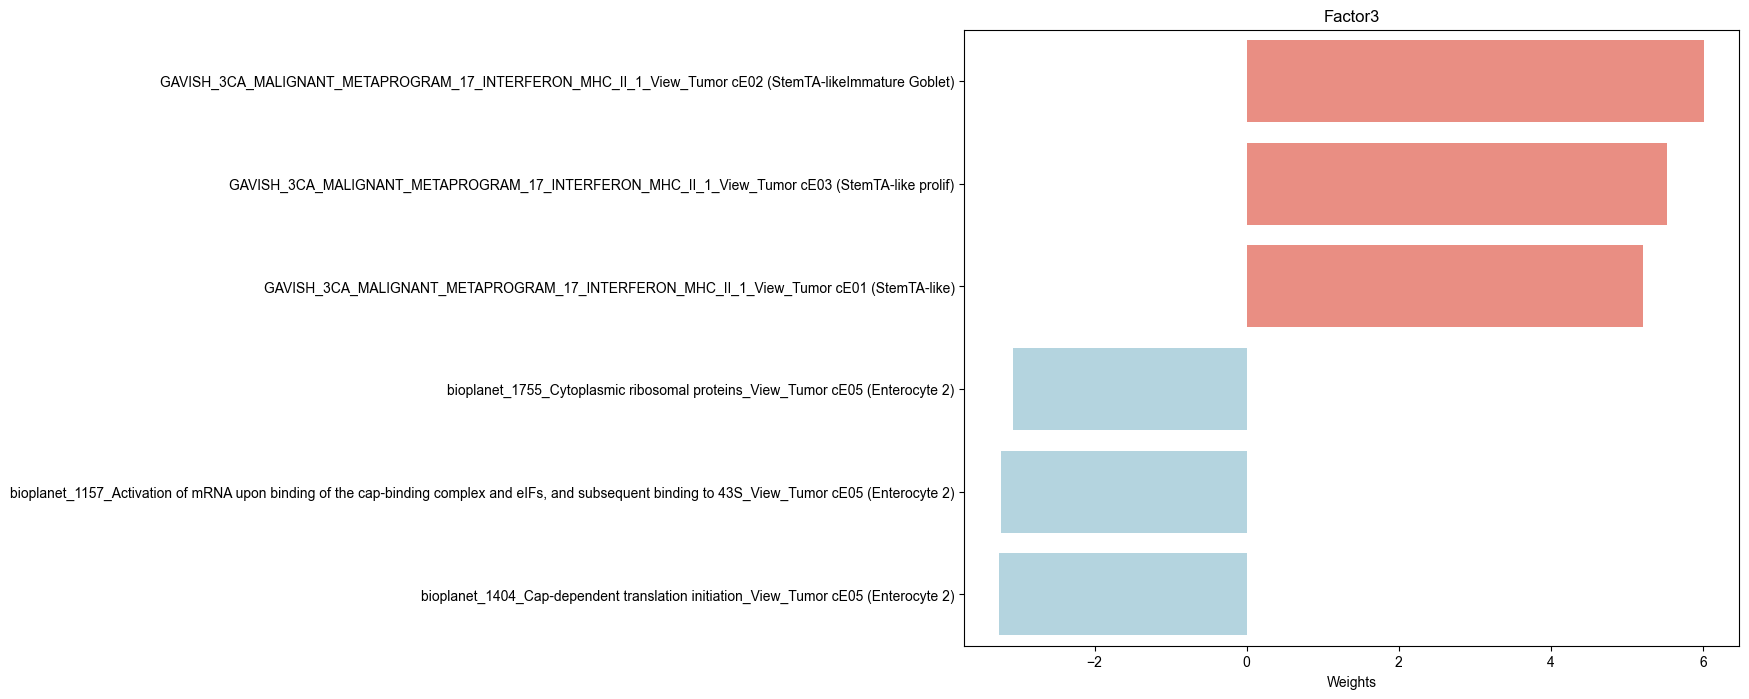

In [10]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor3',label_beside_bar=False,n_largest=3,n_smallest=3)
a1.savefig('../CRC/figure_CRC/20240103_CRC_cluster_butterfly_factor3.pdf',bbox_inches = "tight")
plt.show()

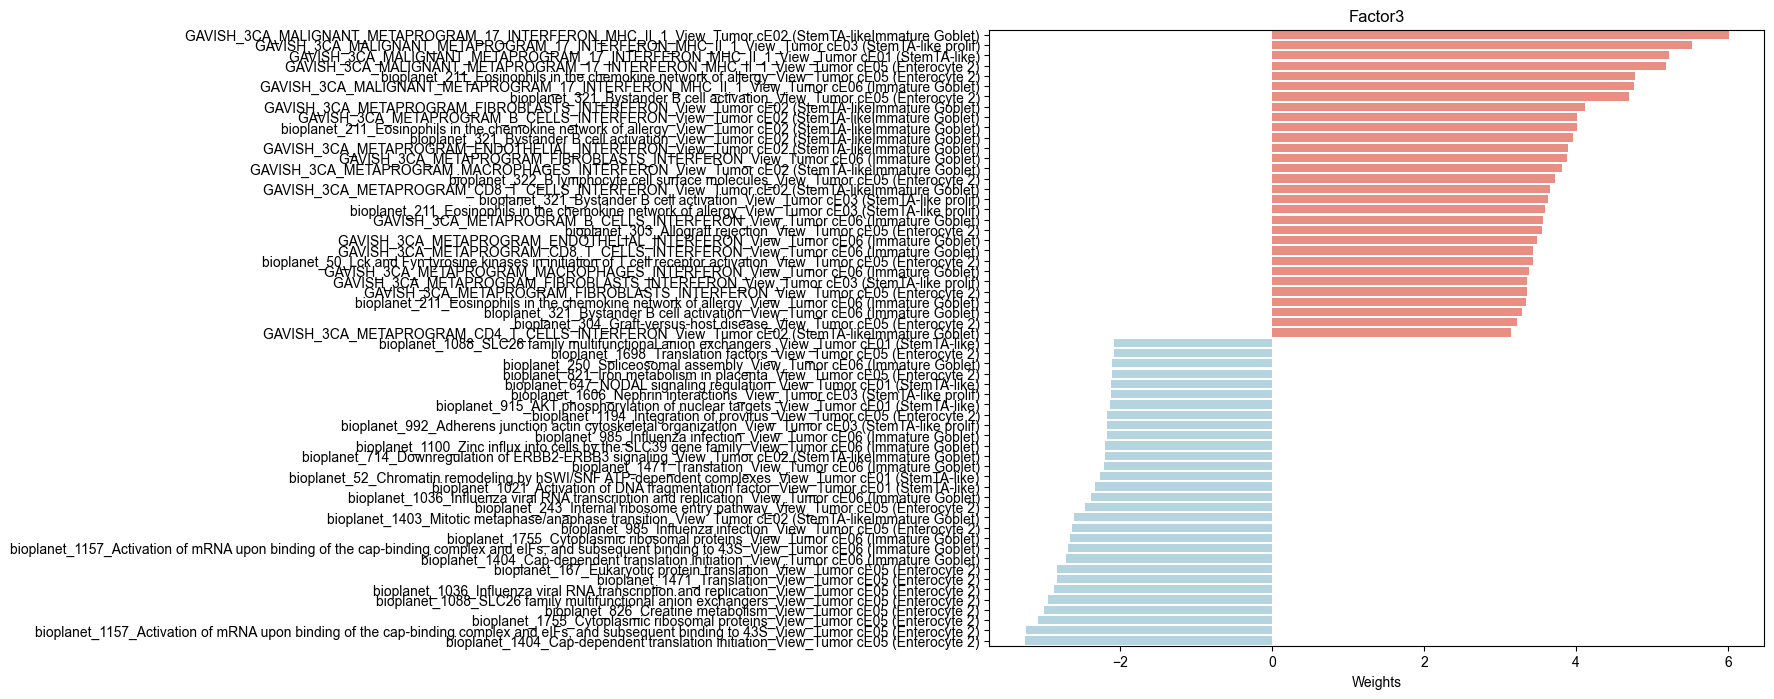

In [5]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor3',label_beside_bar=False,n_largest=30,n_smallest=30)

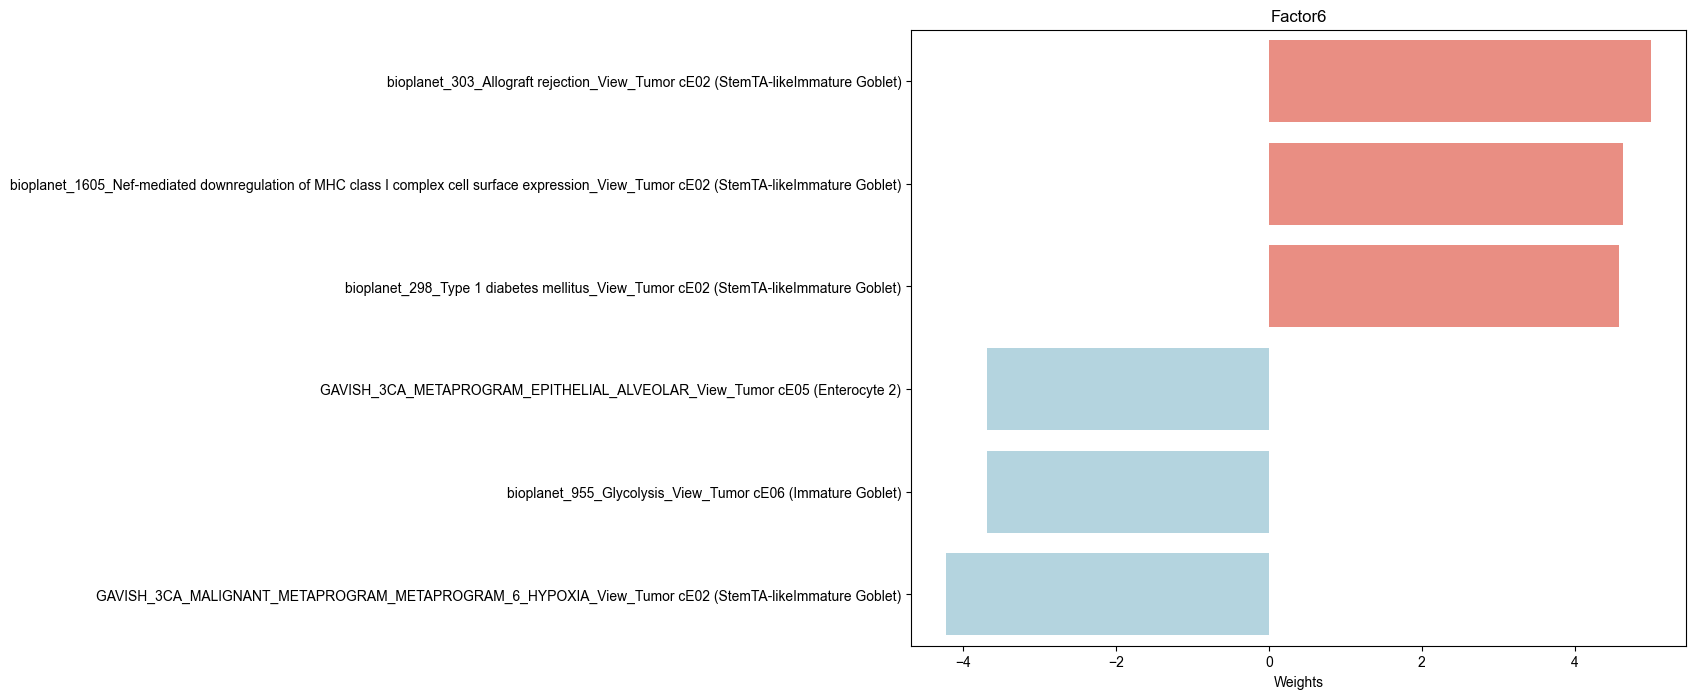

In [11]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor6',label_beside_bar=False,n_largest=3,n_smallest=3)
a1.savefig('../CRC/figure_CRC/20240103_CRC_cluster_butterfly_factor6.pdf',bbox_inches = "tight")
plt.show()

In [ ]:
a1 = scPAFA.pl.plot_weights_butterfly(weight_matrix=weight_matrix,factor_name='Factor6',label_beside_bar=False,n_largest=3,n_smallest=3)